In [51]:
using Revise
using Random

using StatsPlots
pyplot()
using Distributions

using Printf


using ramnet
using ramnet.Encoders

using PyCall
gym = pyimport("gym")

using ProgressMeter

┌ Info: Precompiling ProgressMeter [92933f4c-e287-5a05-a399-4b506db050ca]
└ @ Base loading.jl:1278


# Cartpole with Weightless Neural Networks

In [155]:
function scale(value, min, max)
    (value - min)/(max - min)
end

function scale_state(state)
    return [
        scale(state[1], -4.8, 4.8),
        scale(state[2], -4.0, 4.0),
        scale(state[3], -0.418, 0.418),
        scale(state[4], -3.0, 3.0)
    ]
end

function experiences(states, actions, rewards, last_transitions, gamma)
    # tuples = Vector{Tuple{Vector{Float64},Int64,Float64}}(undef, length(states))
    tuples = []
    startpoint = last_transitions[end]
    i = 1
    for endpoint in Iterators.reverse(last_transitions[1:end-1])
        G = 0
        for step in startpoint:-1:endpoint+1
            G = gamma*G + rewards[step]
            # tuples[i] = (states[step], actions[step], G)
            push!(tuples, (states[step], actions[step], G))
            i += 1
        end
        startpoint = endpoint
    end
        
    return tuples
end


struct WisardAgent
    actions::Vector{Int64}
    size::Int64
    n::Int64
    γ::Float64
    thermo::Thermometer
    Q̂::Dict{Int64,RegressionDiscriminator}
end

function WisardAgent(actions, size, n, thermo; γ = 1.0)
    WisardAgent(actions, size, n, γ, thermo, Dict(a => RegressionDiscriminator(size, n; γ) for a in actions))
end

function reset!(agent::WisardAgent)
    for (a, _) in agent.Q̂
        agent.Q̂[a] = RegressionDiscriminator(agent.size, agent.n; agent.γ)
    end
end

function train_agent!(agent::WisardAgent, experiences)
    for (state, action, target) in experiences
        train!(agent.Q̂[action], encode(agent.thermo, scale_state(state)), target)
    end
end

function act(agent::WisardAgent, state)
    best_Q = typemin(Float64)
    best_action = 0       
    for (action, V̂) in agent.Q̂
        v = predict(V̂, encode(agent.thermo, scale_state(state)))
                
        if v > best_Q
            best_action = action
            best_Q = v
        end
    end
    
    return best_action
end


struct SimulationLoop
    env::PyObject
    agent::WisardAgent
    gamma::Float64
    ϵ::Float64
    exp_batch_size::Int64
    rng::MersenneTwister
end

function SimulationLoop(env, agent, gamma, ϵ, exp_batch_size; seed=nothing)
    SimulationLoop(
        env,
        agent,
        gamma,
        ϵ,
        exp_batch_size,
        isnothing(seed) ? MersenneTwister() : MersenneTwister(seed)
    )
end

function run(loop::SimulationLoop, episodes=100, random_start=0)
    states, actions, rewards, last_transitions = [], [], [], [0]
    steps = 1
        
    cum_rewards = Vector{Float64}(undef, episodes)
    @showprogress for epi in 1:episodes
        state = loop.env.reset()
        push!(states, state)

        cum_reward = 0.0
        while true
            if epi <= random_start || rand(loop.rng) < loop.ϵ
                action = loop.env.action_space.sample()
            else
                action = act(loop.agent, state)
            end
            
            state, reward, done, _ = loop.env.step(action)

            cum_reward += reward

            push!(rewards, reward)
            push!(actions, action)

            if done
                push!(last_transitions, steps)
                break
            else
                push!(states, state)
            end
            steps += 1
        end

        cum_rewards[epi] = cum_reward

        if epi % loop.exp_batch_size == 0
            # train and clean experiences' lists
            # @show experiences(states, actions, rewards, last_transitions, loop.gamma)
            train_agent!(loop.agent, experiences(states, actions, rewards, last_transitions, loop.gamma))
            states, actions, rewards, last_transitions = [], [], [], []
            steps = 1
        end
    end
    return cum_rewards
end

# Simulate episode for a given environment and agent
function run_episode(env, agent; render=false)
    state = env.reset()
    cum_reward = 0.0
    
    while true
        if render
            env.render()
            sleep(1/60)
        end
            
        action = act(agent, state)
        state, reward, done, _ = env.step(action)
        
        cum_reward += reward
        
        if done
            break
        end
    end 
    if render
        env.close()
    end
        
    return cum_reward
end


# Measure the mean cumulative reward of a episode for a given environment
# following the policy of a given agent
function mean_cum_reward(env, agent, n)
    # return np.mean([run_episode(env, agent) for _ in range(n)])
    mean([run_episode(env, agent) for _ in 1:n])
end

# Run a RL experiment with a given environment, learning algorithm and parametrization
# Returns a matrix where each row contains the cumulative rewards obtaining in the respective
# training replicaton
function experiment(replications, env, agent; gamma=1.0, epsilon=0.0, exp_batch_size=1, episodes=100, random_start=0, seed=nothing)
    loop = SimulationLoop(env, agent, gamma, epsilon, exp_batch_size; seed)
    
    # result = np.empty((replications, episodes))
    result = Array{Float64,2}(undef, replications, episodes)
    
    for i in 1:replications
        result[i,:] = run(loop, episodes, random_start)
        reset!(agent)
    end

    return result
end


# Plot a learning curve from the results of a experiment
function learning_curve(experiment_result)
    # episodes = experiment_result.shape[1]
    plot(permutedims(mean(experiment_result; dims=1)), legend=false)
end

learning_curve (generic function with 1 method)

## Original Regression WiSARD

Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


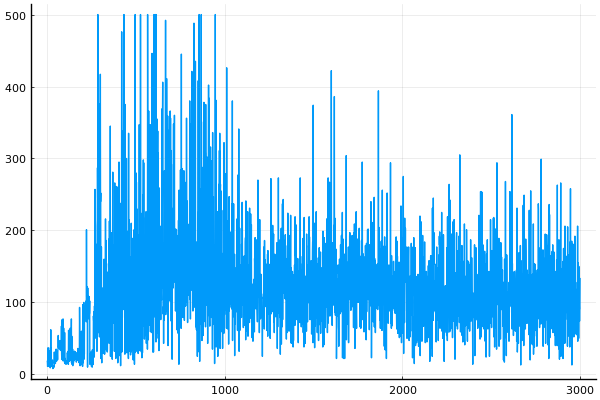

In [125]:
res = 150
n = 20

env = gym.make("CartPole-v1")
thermo = Thermometer(0.0, 1.0, res)

wagent = WisardAgent([0, 1], 4*res, n, thermo; γ = 1.0)
loop = SimulationLoop(env, wagent, 1.0, 0.06, 20; seed=1)

cum_rewards = run(loop, 3000, 30)

plot(cum_rewards, legend=false)

In [191]:
run_episode(env, wagent; render=true)

91.0

In [141]:
mean_cum_reward(env, wagent, 500)

111.892

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08
Progress: 100%|█████████████████████████████████████████| Time: 

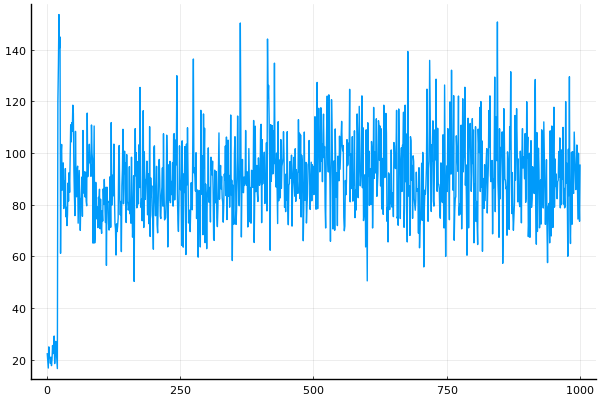

In [185]:
res = 90
n = 30

results = experiment(
    15,
    gym.make("CartPole-v1"),
    WisardAgent([0, 1], 4*res, n, Thermometer(0.0, 1.0, res); γ = 1.0);
    epsilon=0.01,
    exp_batch_size=5,
    episodes=1000,
    random_start=20
)

learning_curve(results)

## Regression WiSARD with decaying weight

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:26
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:20
Progress: 100%|█████████████████████████████████████████| Time: 0:00:26
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
Progress: 100%|█████████████████████████████████████████| Time: 

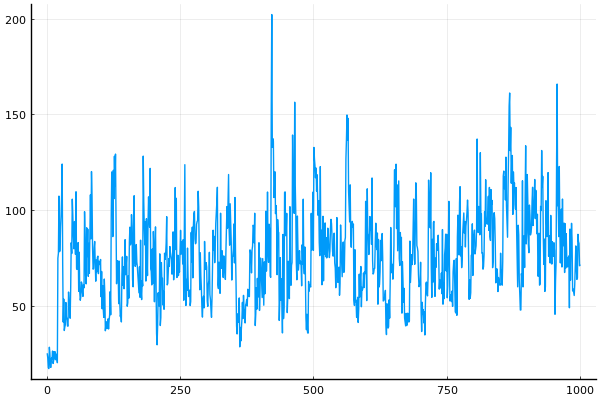

In [201]:
res = 256
n = 8

results = experiment(
    15,
    gym.make("CartPole-v1"),
    WisardAgent([0, 1], 4*res, n, Thermometer(0.0, 1.0, res); γ = 0.95);
    epsilon=0.01,
    exp_batch_size=5,
    episodes=1000,
    random_start=20
)

learning_curve(results)

In [178]:
res = 90
n = 30

env = gym.make("CartPole-v1")
thermo = Thermometer(0.0, 1.0, res)

wagent_decay = WisardAgent([0, 1], 4*res, n, thermo; γ = 0.85)
loop = SimulationLoop(env, wagent_decay, 1.0, 0.01, 5; seed=1)

cum_rewards = run(loop, 1000, 20);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


In [197]:
run_episode(env, wagent_decay; render=true)

164.0